In [ ]:
package = ['boto3','es_lemmatizer','pyodbc','prince']
f= open("paquetes.txt","w+")

def install_txt(package):
  f= open("paquetes.txt","w+")
  for i in package:
    print(i)
    

    try:
        __import__(i)
        print('ya instalado {}'.format(i))
    except ImportError:
        # main(['install', package]) 
        f.write("{} \r\n".format(i))
        print('No instalado {}'.format(i))


install_txt(package)  

boto3
ya instalado boto3
es_lemmatizer
ya instalado es_lemmatizer
pyodbc
ya instalado pyodbc
prince
ya instalado prince


In [ ]:
!pip install -r paquetes.txt

#**Librerias**

In [ ]:
#Librerias
import re
import numpy as np
import pandas as pd
import pandas_profiling
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
nltk.download('stopwords')
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import unicodedata
from es_lemmatizer import lemmatize
import spacy
import re
import pyodbc
import prince
import os
from sklearn.feature_extraction.text import CountVectorizer
import plotly.express as px

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


#**Rutas**

In [ ]:
#Rutas en Drive colab
os.getcwd()

'/content'

In [ ]:

Campaña_P  = "/content/Modelo Analítico PCP - Beneficio Educativo.xlsx"

#**Funciones**

In [ ]:
# CONEXION A SERVIDOR ###################################################################################
# def Conexion():
#     server = '172.27.48.148'
#     #database = 'bdcmp_NuevaEpsCrm' 
#     username = 'CienciaDatos' 
#     password = 'C13nc1aD47*5'  
#     cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';UID='+username+';PWD='+ password)
#     cursor = cnxn.cursor()
#     return cnxn


# DEFINICION DE PICOS Y FECHAS ##################################################################################
##Se definen fechas para realizar los respectivos filtros 
##cuando se extraiga la información correspondiente desde el servidor

def fechas(df_Tipo_OF):
    df_OF = df_Tipo_OF.astype(str).replace('NaT','20200101')
#######Operaciones financieras
    df_OF ['fecha_ini_1'] = df_OF['Picos de demanda  1'].replace(regex=r'-', value = '').replace('0','20200101')
    df_OF ['fecha_fin_1'] = ['20210401','20210301','20210301','20210301', '20210301', '20210301', '20210401']
    df_OF ['fecha_ini_2'] = df_OF['Picos de demanda  2'].replace(regex=r'-', value = '').replace('0','20200101')
    df_OF ['fecha_fin_2'] = ['20210501', '20210501', '20200101', '20210501', '20200101', '20210501', '20201001']
    df_OF ['fecha_ini_3'] = df_OF['Picos de demanda  3'].replace(regex=r'-', value = '').replace('0','20200101')
    df_OF ['fecha_fin_3'] = ['20210601', '20200101', '20200101', '20210601', '20200101', '20200101', '20210101']
    
    return df_OF  

## EXTRACCIÓN ########################################################################################################

def Extraccion(df_fechas, df_General, picos):
    #df_fechas : Nombre de la tabla con las tipologias seleccionadas y las fechas definidas correspondientes (con la función de fechas)
    #df_general : Nombre de tabla para cada campaña sin las fechas definidas 
    #picos : Número máximo de picos que se analizan [en OF son 2, en P son 3]
    
    query_base = "SELECT * FROM [172.27.90.50].[Ecopetrol_Reporting].[dbo].[Tbl_Ecopetrol_ResultadoBackOffice] "
    
    i = 0 
    cnxn = Conexion()
    query = "WHERE ([fgs_Nivel3] = '"+ df_fechas['Nivel 3'][i] + "') AND ([fgs_FechaInicio] BETWEEN '" + df_fechas['fecha_ini_1'][i]+ "' AND '" + df_fechas['fecha_fin_1'][i] +"')"  
    query_completa = query_base + query
    df_inicial = pd.read_sql(query_completa, cnxn)

    for j in range(1,picos+1):
        df_General["Datos_Pico_"+str(j)] = 0
        for i in range(0,len(df_fechas['Campaña'])):
            cnxn = Conexion()
            query = "WHERE ([fgs_Nivel3] = '"+ df_fechas['Nivel 3'][i] + "') AND ([fgs_FechaInicio] BETWEEN '" + df_fechas["fecha_ini_"+str(j)][i]+ "' AND '" + df_fechas["fecha_fin_"+str(j)][i] +"')"  
            query_completa = query_base + query
            df = pd.read_sql(query_completa, cnxn)
            df_total = pd.concat([df_inicial,df]).drop_duplicates()
            df_inicial = df_total
            df_General["Datos_Pico_"+str(j)][i] = df.shape[0] 
    print('Total de registros:', df_inicial.shape[0])
    print('Total de columnas:', df_inicial.shape[1])
            
    return df_total,df_General                 

# VALORES FALTANTES ###############################################################################################################################################################################################

def Valores_Faltantes(df, porcentaje):
    Faltantes = df.isnull().sum()
    df_Faltantes = pd.DataFrame({'Nombre_Columnas':Faltantes.index, 'Total_Vacios':Faltantes.values})#[df_Faltantes['Total_Vacios'] != 0]
    df_Faltantes = df_Faltantes[df_Faltantes['Total_Vacios'] != 0]

    df_Faltantes['Porcentaje_vacio'] = ((df_Faltantes['Total_Vacios']/df.shape[0])*100).round(2)
    df_Faltantes['Columna_vacia'] = 'NO'
    df_Faltantes.loc[df_Faltantes['Total_Vacios'] == df.shape[0], 'Columna_vacia'] = 'SI'
    
    print('Total columnas con valores faltantes :', df_Faltantes.shape[0])
    print('Total columnas vacias :', df_Faltantes[df_Faltantes['Columna_vacia'] == 'SI'].Columna_vacia.count())
    print('Total columnas no vacias con mas del ' + str(porcentaje) + '% de valores faltantes :', df_Faltantes[(df_Faltantes['Porcentaje_vacio'] >= porcentaje) & (df_Faltantes['Columna_vacia'] == 'NO') ].Columna_vacia.count())
    #print('Total columnas no vacias con menos del ' + str(porcentaje) + '% de valores faltantes :', df_Faltantes[(df_Faltantes['Porcentaje_vacio'] >= porcentaje) & (df_Faltantes['Columna_vacia'] == 'NO') ].Columna_vacia.count())
    
    return df_Faltantes

# ELIMINAR COLUMNAS##############################################################################################

#para eliminar columnas seleccionadas
def Eliminar_columnas(df, lista_columnas):
    df_drop = df.drop(columns = lista_columnas)
    print ('Cantidad de columnas iniciales : ', df.shape[1])
    print ('Cantidad despues de eliminar : ', df_drop.shape[1] )
    return df_drop
### elimincacion 100 valores nulos, cardinalida100, cardinalidad 1
def eliminacion_columnas(tabla):
  cardinalidad100 = tabla[tabla['% de valores diferentes']==100]
  cardinalidad1 = tabla[tabla['# de valores diferentes']==1]
  vacios = tabla[tabla['% de datos nulos']==100]
  variables_eliminar=vacios.index.tolist()+cardinalidad1.index.tolist()+cardinalidad100.index.tolist()# no aportan informacion
  print('numero de variables a eliminar : {}'.format(len(variables_eliminar)))
  return variables_eliminar
# columnas duplicadas
def columnas_dup(df):
    df_dup = df.T.duplicated().T
    return df_dup
#Para eliminar columnas duplicadas
def columnas_nodup(df):
    print ('Total de columnas antes de eliminar dup: ', df.shape[1])
    df_sindup = df.T.drop_duplicates().T
    print ('Total de columnas duplicadas : ', df.shape[1] - df_sindup.shape[1])
    print ('Total de columnas no duplicadas:', df_sindup.shape[1])
    return df_sindup    

def mytable(data):
    nulls = pd.DataFrame(data.isnull().sum()/data.shape[0]*100, columns=['% de datos nulos'])
    ceros = pd.DataFrame((data==0).sum()/data.shape[0]*100, columns=['% de ceros'])
    tipo = pd.DataFrame(data.dtypes,columns=['Tipo de datos'])
    val = pd.DataFrame(data.nunique(),columns=['# de valores diferentes'])
    valpor = pd.DataFrame(data.nunique()/data.shape[0]*100,columns=['% de valores diferentes'])
    mis_val_table = pd.concat([nulls, ceros,tipo, val, valpor], axis=1)
    return mis_val_table

def creacion_tabla(x):
  tabla_x = mytable(x)
  print(x.shape)
  return tabla_x


def nonum(x):
 try:
   int(x)
   sal = False
 except:
    sal = True
 return sal 


def isnum(x):
 try:
   int(x)
   sal = True
 except:
    sal = False
 return sal 

def solo_num(x):
  try:
    sal = float(x)
  except:
    sal = np.nan
  return sal 
def creacion_tabla(x):
  tabla_x = mytable(x)
  print(x.shape)
  return tabla_x





#esta funcion quita stop words de cada una de las filas
def text_rows(texto, StopWords):
    texto = texto.split()
    resultwords  = [word for word in texto if word not in StopWords]
    texto = ' '.join(resultwords)
    return texto


def text (column, dic):
    column = column.astype(str)
    texto_base = " ".join(motivo for motivo in column)
    text = (unicodedata.normalize('NFKD', texto_base).encode('ascii', 'ignore').decode('utf-8', 'ignore').lower())
    text = re.sub(r"\bmedicas\b","medica",text)
    for i, j in dic.items():
        text = text.replace(i, j)
        
    return text
    
def listas (column, dic):
    Lista = []
    column = columna.astype(str)
    for motivo in column:
        inicial_answer = str(motivo)
        for i, j in dic.items():
            ini_answer = inicial_answer.replace(i, j)
        answer = (unicodedata.normalize('NFKD', ini_answer).encode('ascii', 'ignore').decode('utf-8', 'ignore').lower())
        answer = re.sub(r"\bmedicas\b","medica",answer)
        answer = re.sub(r"\bmedicamentos\b","medicamento",answer)
        answer = re.sub(r'[^\w\s]','', answer).split()
        words = [word for word in answer if word not in stop_words]
        Lista.append(words)
    return Lista
    
#crea nube de palabras
def wordcloud(text, nombre, stopWords):
    # wordcloud = WordCloud(stopwords=stop_words+stopWords, background_color="white", width=1600, height=800,min_word_length =3 ).generate(text)
    wordcloud = WordCloud(stopwords=stop_words+stopWords, background_color="white", width=1600, height=800).generate(text)
    plt.figure( figsize=(15,10) )
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    plt.savefig("word_cloud_"+str(nombre)+".png") #dpi = 300)    

#crea n-gramas   
def ngrams(text, n, top,stopWords):
    #wnl = nltk.stem.WordNetLemmatizer()
    texto = re.sub(r'[^\w\s]','', text).split()
    stopwords = stop_words + stopWords
    words = [word for word in texto if word not in stopwords]
    
    n_grams_series = ((pd.Series(nltk.ngrams(words,n)).value_counts())[:top])
    plot = n_grams_series.sort_values().plot.barh(color ="tomato", width = 0.6, figsize = (20,18), edgecolor='grey')   #color=(0.2, 0.4, 0.6, 0.6)
    plot.set_xlabel('Frecuencia',  fontname="Calibri", fontsize=35)
    plot.set_title('TOP ' + str(top) +' de '+str(n)+'-GRAMAS QUE APARECEN CON MAYOR FRECUENCIA', fontname="Calibri", fontsize=40)
    plot.title.set_position([.5, 1.05])
    for tick in  plot.get_xticklabels():
        tick.set_fontname("Calibri")
        tick.set_fontsize(35)
    for tick in  plot.get_yticklabels():
        tick.set_fontname("Calibri")
        tick.set_fontsize(35)
    #plt.savefig("graph.png") #dpi = 300)
    plt.figure( figsize=(15,10) )
    #plt.show()
    return n_grams_series
    #if n == 1 :
    #    return n_grams_series.to_frame().reset_index().rename(columns = {'index':'palabras', 0:'Conteo'})
    #elif n == 2:
    #    return n_grams_series.to_frame().reset_index().rename(columns = {'index':'Bigramas', 0:'Conteo'})
    #elif n > 2:
    #    return n_grams_series.to_frame().reset_index().rename(columns = {'index':'gramas', 0:'Conteo'})

def wordcloud_jose(x):
  lista_mensajeuser=[]
  
  long_string=''.join(x)
  sal = pd.Series(long_string.split(' ')).value_counts()
  saldic = sal.to_dict()
  #Creacion lista stop words
  wordcloud = WordCloud(background_color="white",min_font_size=5, max_font_size=150, max_words=600, contour_width=50,
                        contour_color='steelblue', margin=15, stopwords=StopWords_total,width=1600, height=800)
  
  wordcloud2 = WordCloud(background_color="white",min_font_size=5, max_font_size=150, max_words=20, contour_width=50,
                      contour_color='steelblue', margin=15, stopwords=StopWords_total,width=1600, height=800)
  #Crear el word cloud
  #wordcloud.generate(long_string)
  wordcloud.generate_from_frequencies(saldic)
  wordcloud2.generate_from_frequencies(saldic)
  # wordcloud.generate(saldic)
  #Visualizar el word cloud
  plt.figure( figsize=(15,10) )
  
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()
  
  plt.figure( figsize=(15,10) )
  plt.imshow(wordcloud2, interpolation='bilinear')
  plt.axis("off")
  plt.show()


def plot_10_most_common_words(count_data, count_vectorizer):
   #Grafico de frecuencias
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:15]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    fig = px.bar( x=words, y=counts, color_discrete_sequence=["#25427B","#33BBFF","#EBECED"], title='TÉRMINOS MÁS COMUNES EN:'+' '+segmento,  labels=dict(x="Palabra Clave", y="Frecuencia", color="Place")) #COLORES DE ECOPETROL, PUEDES VARIAR LOS COLORES
    fig.write_html(segmento+"_.html")
    fig.show()
    return words,counts


# **EXTRACCIÓN**

In [ ]:
observador_personal  = '/content/drive/MyDrive/Ecopetro/Estefania/Observaciones_LimpiezaInicial_Personal.csv'

In [ ]:
beneficios = pd.read_csv(observador_personal)
beneficios.head()

,fgs_IdGestion,fgs_Nivel3,ObservacionCreacion_limpieza1,ObservacionSolucion_limpieza1,ObservacionEscalamientoN2_limpieza1,# palabras_ObsCreacion_sinLim,# palabras_ObsSolucion_sinLim,# palabras_ObsEscalamientoN2_sinLim,# palabras_ObsCreacion_limpieza1,# palabras_ObsSolucion_limpieza1,# palabras_ObsEscalamiento_limpieza1
0,13908445,Legal / Reconocimiento Pensionados (Incluye Su...,se recibe documentacion del senor joaquin erne...,se informa que su caso no puede ser tramitado...,vacio,18,228,1,18,238,1
1,13908527,Legal / Reconocimiento Pensionados (Incluye Su...,solicito el ajuste de semestre y se encuentra ...,se realizo el ajuste de semestre y se encuentr...,vacio,12,13,1,12,13,1
2,13908581,Legal / Reconocimiento Pensionados (Incluye Su...,se recibe solicitud de legalizacion semestre s...,se informa a la peticionaria que este caso fue...,vacio,20,17,1,18,16,1
3,13908589,Legal / Reconocimiento Pensionados (Incluye Su...,solicitud del usuario ayer envie este mismo do...,gestion realizada dando respuesta a la consult...,vacio,22,250,1,25,247,1
4,13908640,Legal / Reconocimiento Pensionados (Incluye Su...,se recibe solicitud de legalizacion de luisa f...,se informa que debe anexar certificacion de un...,vacio,10,27,1,10,27,1


In [ ]:
texto = 'su solicitud de anticipo del beneficio educativo puede realizarlo allegando el formato gth f version vigente solicitud de anticipo junto con los soportes indicados en el documento y debe ser radicado en el cal mas cercano presentando el formato original con firma original del titular el anticipo se debe legalizar en un plazo no mayor a dias en caso que presente inconvenientes con el ingreso a que debido a la contingencia de salud sanitaria por motivo de covid el area encargada ha habilitado el buzon oficinavirtualdepersonal ecopetrol com co para remitir los documentos pertinentes y acceder a los anticipos de beneficio educacional por lo anterior usted debe remitir por este medio los documentos formato gth f version vigente diligenciado y firmado por el titular adjunto a este correo uno de los siguientes documentos a certificado emitido por la institucion educativa donde indique el valor de la matricula ordinaria a cancelar o b circular de la institucion educativa donde se relacionen los valores aprobados para el periodo academico o c copia del recibo de pago y o orden de matricula actual o del ultimo semestre pagado a la institucion con sello de cancelado de la universidad en caso de pagos electronicos debe presentar soporte de la transferencia donde se observe que la transaccion fue exitosa o aceptada anexando documento de la universidad que detalle el valor ordinario de matricula u orden de la institucion educativa donde se indique el valor a cancelar de la matricula ordinaria del semestre a cursar para solicitudes de primer semestre certificado de admision o carta de aceptacion por parte de la institucion educativa y anexar programa academico pensum malla curricular el acuerdo de compromiso adjunto a este correo recuerde que para utilizar este beneficio no debe tener solicitudes'
mapa = beneficios['ObservacionSolucion_limpieza1'].astype(str).map(lambda x : x.find(texto)!=-1)


In [ ]:
x = beneficios[mapa]
y = x['fgs_IdGestion']
y.to_excel('error.xlsx')


In [ ]:
len(y)


23

In [ ]:
# beneficios[mapa]['ObservacionSolucion_limpieza1'][6306]

In [ ]:
beneficios['# palabras_ObsSolucion_limpieza1'].describe(percentiles = [ 0.05,0.15,0.25,0.5,0.75,0.85,0.95,0.99])

count    13748.000000
mean        50.331175
std         70.134088
min          0.000000
5%           5.000000
15%          8.000000
25%         11.000000
50%         25.000000
75%         51.000000
85%         83.000000
95%        218.000000
99%        344.000000
max        474.000000
Name: # palabras_ObsSolucion_limpieza1, dtype: float64

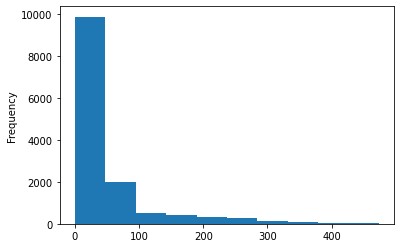

In [ ]:
beneficios['# palabras_ObsSolucion_limpieza1'].plot.hist()

In [ ]:
mytable(beneficios[['fgs_IdGestion', 'fgs_Nivel3', 'ObservacionCreacion_limpieza1',
'ObservacionSolucion_limpieza1', 'ObservacionEscalamientoN2_limpieza1']])

,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
fgs_IdGestion,0.000000,0.0,int64,13748,100.000000
fgs_Nivel3,0.000000,0.0,object,20,0.145476
ObservacionCreacion_limpieza1,0.000000,0.0,object,11624,84.550480
ObservacionSolucion_limpieza1,0.014548,0.0,object,11031,80.237125
ObservacionEscalamientoN2_limpieza1,0.000000,0.0,object,2857,20.781205


In [ ]:
beneficios.shape

(13748, 11)

## **GRUPOS**

In [ ]:
GRUPOS = ['1. Legalización','1. Legalización','2. Solicitud de educación inclusiva'
          ,'3. Anticipo','3. Anticipo','3. Anticipo','3. Anticipo'
          ,'4. Consulta','4. Consulta','4. Consulta','4. Consulta','4. Consulta'
          ,'4. Consulta','4. Consulta','5. Soporte Plataforma'
          ,'6. Reintegro','6. Reintegro','7. Inscripción','7. Inscripción','7. Inscripción']

NIVELES = ['Legal / Reconocimiento Pensionados (Incluye Sustitutos)'
           ,'Legal / Reconocimiento Trabajadores (Incluye Bachiller ECP)'
           ,'Solicitud de educación inclusiva'
           ,'Anticipo Pensionados Educación Inclusiva','Anticipo Trabajadores Educación Inclusiva'
            ,'Anticipo Pensionados (Incluye Sustitutos)','Anticipo Trabajadores (Incluye BXC)'
            ,'Consulta Bachiller Ecopetrol (Incapacidad médica y/o Fuerza Mayor)'
            ,'Consulta de información relacionadas con reembolsos'
            ,'Consulta especialista beneficios atención PQRS'
            ,'Consulta sobre liquidación/pago préstamo para educación'
            ,'Consulta Titulares Beneficio Eductivo - Desvinculados'
            ,'Consultas Titulares Beneficio Educativo (No Incluye Bachiller ECP)'
            ,'Solicitud / Consulta / revisión pagos colegios propiedad de Ecopetrol S.A.'
            ,'Soporte Plataforma para Instituciones Educativas vía TIB'
            ,'Reintegro de dinero Pensionados Educación (Incluye sustitutos y Auto)'
            ,'Reintegro de dinero trabajadores Educación (Incluye Bachiller ECP)'
            ,'Inscripción casos especiales comité de educación convencional activos'
            ,'Inscripción casos especiales comité educación convencional pensionados'
            ,'Inscripción solicitud becas Comité de Educación Convencional Activos']

dic_grupos = dict(zip(NIVELES,GRUPOS))

beneficios['GRUPOS'] = beneficios['fgs_Nivel3']
beneficios['GRUPOS'].replace(dic_grupos, inplace=True)

In [ ]:
interes = beneficios[[ 'GRUPOS', 'ObservacionCreacion_limpieza1',
'ObservacionSolucion_limpieza1', 'ObservacionEscalamientoN2_limpieza1']].copy()
original =interes.copy()

for i in interes.columns:
  display(interes[i].value_counts())
  print('_'*100)

1. Legalización                        6610
3. Anticipo                            3428
4. Consulta                            1348
5. Soporte Plataforma                  1121
7. Inscripción                          466
2. Solicitud de educación inclusiva     414
6. Reintegro                            361
Name: GRUPOS, dtype: int64

____________________________________________________________________________________________________


solicita informacion de plan educacional                                                                                                                                                                                                                                                                                         283
solicita informacion                                                                                                                                                                                                                                                                                                             195
se recibe por parte de oficina virtual solicitud legalizacion plan educacional                                                                                                                                                                                                                                                   169
legalizacion plan educaci

____________________________________________________________________________________________________


se procede a dar cierre segun correo adjunto                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

____________________________________________________________________________________________________


vacio                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                10752
gestion su caso se escalo al area encargada para su tramite con las siguientes observaciones cordial saludo a

____________________________________________________________________________________________________


## Limpieza nivel general

In [ ]:
guiones=["consulta de facturas","solicita informacion de estado de factura","solicita informacion de las facturas","consulta factura","estado de factura",]
mapa_guiones ={i : '' for i in guiones}

In [ ]:
interes.columns

Index(['GRUPOS', 'ObservacionCreacion_limpieza1',
       'ObservacionSolucion_limpieza1', 'ObservacionEscalamientoN2_limpieza1'],
      dtype='object')

memo

Cordial Saludo, Estimado(a) Nombre y Apellido.

 

Desde Servicios Compartidos mantenemos una comunicación clara y oportuna con nuestros clientes, por eso a continuación encontrará toda la información relacionada con la solicitud referente a “Solicitud del usuario”.

 

Ingresar información adicional que entregue solución al caso.

 

Su caso quedo registrado y escalado con el número de registro: Id titan XXX

Sus opiniones son importantes para nosotros, con el fin de seguir apuntando nuestros esfuerzos a la mejora de los servicios ofrecidos.

Queremos informarle que desde el Contact Center disponemos de varios canales de contacto para la atención de solicitudes relacionadas con servicios al personal:

Canales telefónicos: 018000918418 línea gratuita nacional, 2345000 línea directa Bogotá; línea directa de atención para funcionarios extensión 45000, desde las instalaciones de Ecopetrol.
Canal Chat: https://achatecop.americasbps.com:9443/webapi/WEBAPI85/Ecopetrol/ChatPersonal/Inicio.jsp
Canal Correo Electrónico: oficinavirtualdepersonal@ecopetrol.com.co
 

Recuerde que sus solicitudes serán atendidas en nuestro horario establecido de Lunes a Viernes de 7:30 am a 4:30 pm.

Gracias por utilizar nuestros servicios de Personal y lo invitamos a continuar con sus solicitudes a través del Portal de Servicios Compartidos o la línea de atención 2345000 o el buzón Oficina Virtual de Personal; cualquier sugerencia, felicitación o queja relacionada con el servicio la puede enviar a través del buzón Quejas y Soluciones. Para Servicios Compartidos es un placer atenderle, le deseamos un feliz día.

## ObservacionCreacion_limpieza1

In [ ]:
mapa = interes['ObservacionCreacion_limpieza1'].map(lambda x: x.find('Cordial Saludo, Estimado(a) Nombre y Apellido'))!=-1
interes['ObservacionCreacion_limpieza1'][mapa]

Series([], Name: ObservacionCreacion_limpieza1, dtype: object)

In [ ]:
texto =  'Desde Servicios Compartidos mantenemos una comunicación clara y oportuna con nuestros clientes, por eso a continuación encontrará toda la información relacionada con la solicitud referente a “Solicitud del usuario”.'
mapa = interes['ObservacionCreacion_limpieza1'].map(lambda x: x.find(texto))!=-1
interes['ObservacionCreacion_limpieza1'][mapa]

Series([], Name: ObservacionCreacion_limpieza1, dtype: object)

In [ ]:
texto = 'Ingresar información adicional que entregue solución al caso.'
mapa = interes['ObservacionCreacion_limpieza1'].map(lambda x: x.find(texto))!=-1
interes['ObservacionCreacion_limpieza1'][mapa]

Series([], Name: ObservacionCreacion_limpieza1, dtype: object)

In [ ]:
texto = 'Su caso quedo registrado y escalado con el número de registro'
mapa = interes['ObservacionCreacion_limpieza1'].map(lambda x: x.find(texto))!=-1
interes['ObservacionCreacion_limpieza1'][mapa]

Series([], Name: ObservacionCreacion_limpieza1, dtype: object)

In [ ]:
texto = 'Sus opiniones son importantes para nosotros, con el fin de seguir apuntando nuestros esfuerzos a la mejora de los servicios ofrecidos.'
mapa = interes['ObservacionCreacion_limpieza1'].map(lambda x: x.find(texto))!=-1
interes['ObservacionCreacion_limpieza1'][mapa]

Series([], Name: ObservacionCreacion_limpieza1, dtype: object)

In [ ]:


texto = 'Queremos informarle que desde el Contact Center disponemos de varios canales de contacto para la atención de solicitudes relacionadas con servicios al personal:'
mapa = interes['ObservacionCreacion_limpieza1'].map(lambda x: x.find(texto))!=-1
interes['ObservacionCreacion_limpieza1'][mapa]

Series([], Name: ObservacionCreacion_limpieza1, dtype: object)

In [ ]:

texto = 'Canales telefónicos: 018000918418 línea gratuita nacional, 2345000 línea directa Bogotá; línea directa de atención para funcionarios extensión 45000, desde las instalaciones de Ecopetrol. Canal Chat:'
mapa = interes['ObservacionCreacion_limpieza1'].map(lambda x: x.find(texto))!=-1
interes['ObservacionCreacion_limpieza1'][mapa]

Series([], Name: ObservacionCreacion_limpieza1, dtype: object)

In [ ]:
texto = 'https://achatecop.americasbps.com:9443/webapi/WEBAPI85/Ecopetrol/ChatPersonal/Inicio.jsp Canal Correo Electrónico: oficinavirtualdepersonal@ecopetrol.com.co'
mapa = interes['ObservacionCreacion_limpieza1'].map(lambda x: x.find(texto))!=-1
interes['ObservacionCreacion_limpieza1'][mapa]


Series([], Name: ObservacionCreacion_limpieza1, dtype: object)

In [ ]:


texto = 'Recuerde que sus solicitudes serán atendidas en nuestro horario establecido de Lunes a Viernes de 7:30 am a 4:30 pm.'
mapa = interes['ObservacionCreacion_limpieza1'].map(lambda x: x.find(texto))!=-1
interes['ObservacionCreacion_limpieza1'][mapa]

Series([], Name: ObservacionCreacion_limpieza1, dtype: object)

In [ ]:

texto = 'Gracias por utilizar nuestros servicios de Personal y lo invitamos a continuar con sus solicitudes a través del Portal de Servicios Compartidos o la línea de atención 2345000 o el buzón Oficina Virtual de Personal; cualquier sugerencia, felicitación o queja relacionada con el servicio la puede enviar a través del buzón Quejas y Soluciones. Para Servicios Compartidos es un placer atenderle, le deseamos un feliz día.'
mapa = interes['ObservacionCreacion_limpieza1'].map(lambda x: x.find(texto))!=-1
interes['ObservacionCreacion_limpieza1'][mapa]

Series([], Name: ObservacionCreacion_limpieza1, dtype: object)

## ObservacionSolucion_limpieza1

### 1

In [ ]:
# mapa = interes['ObservacionSolucion_limpieza1'].astype(str).map(lambda x: x.find('Cordial Saludo, Estimado(a) Nombre y Apellido'))!=-1
text ='cordial saludo'
mapa = interes['ObservacionSolucion_limpieza1'].astype(str).map(lambda x: x.find(text))!=-1
interes['ObservacionSolucion_limpieza1'][mapa]

3        gestion realizada dando respuesta a la consult...
24       vakido caso descripcion cordial saludo nos per...
117      se le informa la respuesta brindada cordial sa...
240      cordial saludo en atencion a su comunicado nos...
274      cordial saludo en atencion a su comunicado nos...
                               ...                        
13441    cordial saludo en atencion a su comunicado nos...
13472    cordial saludo en atencion a su comunicado nos...
13545    cordial saludo en atencion a su comunicado nos...
13618    cordial saludo en atencion a su comunicado nos...
13742    cordial saludo en atencion a su comunicado nos...
Name: ObservacionSolucion_limpieza1, Length: 272, dtype: object

In [ ]:
interes['ObservacionSolucion_limpieza1'][mapa].shape

(272,)

In [ ]:
interes['ObservacionSolucion_limpieza1'][mapa].value_counts()

cordial saludo nos permitimos informarle que su requerimiento fue liquidado con la solic y sera desembolsado el de diciembre de                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              10
cordial saludo informamos que no fue posible dar respuesta positiva ya que este proceso 

In [ ]:
interes['ObservacionSolucion_limpieza1'] = interes['ObservacionSolucion_limpieza1'].astype(str).map(lambda x :x.replace(text,''))

In [ ]:
interes['ObservacionSolucion_limpieza1'][mapa].value_counts()

 nos permitimos informarle que su requerimiento fue liquidado con la solic y sera desembolsado el de diciembre de                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              10
 informamos que no fue posible dar respuesta positiva ya que este proceso lo debe realizar a traves de

### 2

In [ ]:
# texto =  'Desde Servicios Compartidos mantenemos una comunicación clara y oportuna con nuestros clientes, por eso a continuación encontrará toda la información relacionada con la solicitud referente a “Solicitud del usuario”.'
# texto =  'desde servicios compartidos mantenemos una comunicacion'# clara y oportuna con nuestros clientes, por eso a continuación encontrará toda la información relacionada con la solicitud referente a “Solicitud del usuario”.'
texto = 'desde servicios compartidos mantenemos una comunicacion clara y oportuna con nuestros clientes por eso a continuacion encontrara toda la informacion relacionada con la solicitud referente a'

mapa = interes['ObservacionSolucion_limpieza1'].astype(str).map(lambda x: x.find(texto))!=-1
interes['ObservacionSolucion_limpieza1'][mapa]

29       desde servicios compartidos mantenemos una com...
62       desde servicios compartidos mantenemos una com...
108      desde servicios compartidos mantenemos una com...
172      desde servicios compartidos mantenemos una com...
353      desde servicios compartidos mantenemos una com...
                               ...                        
12939    desde servicios compartidos mantenemos una com...
12940    desde servicios compartidos mantenemos una com...
13054    desde servicios compartidos mantenemos una com...
13086    desde servicios compartidos mantenemos una com...
13110    desde servicios compartidos mantenemos una com...
Name: ObservacionSolucion_limpieza1, Length: 230, dtype: object

In [ ]:
interes['ObservacionSolucion_limpieza1'][mapa].shape

(230,)

In [ ]:
interes['ObservacionSolucion_limpieza1'][mapa].value_counts()
# esto estaria bien

desde servicios compartidos mantenemos una comunicacion clara y oportuna con nuestros clientes por eso a continuacion encontrara toda la informacion relacionada con la solicitud referente a su solicitud de anticipo del beneficio educativo puede realizarlo allegando el formato gth f version vigente solicitud de anticipo junto con los soportes indicados en el documento y debe ser radicado en el cal mas cercano presentando el formato original con firma original del titular el anticipo se debe legalizar en un plazo no mayor a dias en caso que presente inconvenientes con el ingreso a que debido a la contingencia de salud sanitaria por motivo de covid el area encargada ha habilitado el buzon oficinavirtualdepersonal ecopetrol com co para remitir los documentos pertinentes y acceder a los anticipos de beneficio educacional por lo anterior usted debe remitir por este medio los documentos formato gth f version vigente diligenciado y firmado por el titular adjunto a este correo uno de los siguie

In [ ]:
interes['ObservacionSolucion_limpieza1'] = interes['ObservacionSolucion_limpieza1'].astype(str).map(lambda x :x.replace(texto,''))

In [ ]:
interes['ObservacionSolucion_limpieza1'][mapa].value_counts()

 su solicitud de anticipo del beneficio educativo puede realizarlo allegando el formato gth f version vigente solicitud de anticipo junto con los soportes indicados en el documento y debe ser radicado en el cal mas cercano presentando el formato original con firma original del titular el anticipo se debe legalizar en un plazo no mayor a dias en caso que presente inconvenientes con el ingreso a que debido a la contingencia de salud sanitaria por motivo de covid el area encargada ha habilitado el buzon oficinavirtualdepersonal ecopetrol com co para remitir los documentos pertinentes y acceder a los anticipos de beneficio educacional por lo anterior usted debe remitir por este medio los documentos formato gth f version vigente diligenciado y firmado por el titular adjunto a este correo uno de los siguientes documentos a certificado emitido por la institucion educativa donde indique el valor de la matricula ordinaria a cancelar o b circular de la institucion educativa donde se relacionen l

In [ ]:
interes.columns

Index(['GRUPOS', 'ObservacionCreacion_limpieza1',
       'ObservacionSolucion_limpieza1', 'ObservacionEscalamientoN2_limpieza1',
       'cantidad de palabras despues de limpieza de memo',
       'cantidad de palabras Original',
       'ObservacionSolucion_limpieza_stop_words'],
      dtype='object')

In [ ]:
interes[mapa].head(10)

,GRUPOS,ObservacionCreacion_limpieza1,ObservacionSolucion_limpieza1,ObservacionEscalamientoN2_limpieza1
29,1. Legalización,se comunica sra nancy beltran madre del sr jho...,la legalizacion de anticipo con caso aprobado...,vacio
62,1. Legalización,sra rojas lopez sophia alejandra solicita el f...,continuacion nos permitimos informarle que en...,vacio
108,1. Legalización,se comunica sra edilma luz guerra madre de gut...,al benefici educativo de su hijo gutierrez gu...,vacio
172,1. Legalización,se comunica sr aza pacheco jose clemente quien...,l reconocimiento del beneficio educativo por c...,vacio
353,1. Legalización,se comunica sr leon cohen orlando alysha leon ...,el reconocimiento del beneficio educativo pue...,vacio
362,1. Legalización,buenas noches lo que pasa es que yo pague el s...,plan educacionalle informamos que debe subir ...,vacio
387,1. Legalización,buenas tardes solicito por favor me informen y...,la legalizacion del benfecio educativo de su ...,vacio
422,1. Legalización,se comunica sr pacheco padilla jorge mario qui...,el beneficio educativo de su beneficiario seb...,vacio
460,1. Legalización,se comunica sra leidy martinez hermana del sr ...,presenta error en kactus actualizacion de dat...,vacio
518,1. Legalización,se comunica sr ortega rozo arturo quien requie...,continuacion nos permitimos informarle que en...,vacio


In [ ]:
texto = 'desde servicios compartidos mantenemos una comunicacion clara y oportuna con nuestros clientes'

mapa = interes['ObservacionSolucion_limpieza1'].astype(str).map(lambda x: x.find(texto))!=-1
interes['ObservacionSolucion_limpieza1'][mapa]

2474     gestion realizada se adjunta correo de respues...
2804     desde servicios compartidos mantenemos una com...
3858     desde servicios compartidos mantenemos una com...
4103     desde servicios compartidos mantenemos una com...
4377     desde servicios compartidos mantenemos una com...
4585     desde servicios compartidos mantenemos una com...
4620     desde servicios compartidos mantenemos una com...
4691     desde servicios compartidos mantenemos una com...
4695     desde servicios compartidos mantenemos una com...
4709     desde servicios compartidos mantenemos una com...
4802     desde servicios compartidos mantenemos una com...
4961     desde servicios compartidos mantenemos una com...
5039     desde servicios compartidos mantenemos una com...
5253     desde servicios compartidos mantenemos una com...
5257     desde servicios compartidos mantenemos una com...
5258     desde servicios compartidos mantenemos una com...
5382     desde servicios compartidos mantenemos una com.

In [ ]:
interes['ObservacionSolucion_limpieza1'][mapa].shape

(30,)

In [ ]:
interes['ObservacionSolucion_limpieza1'][mapa].value_counts()

gestion realizada se adjunta correo de respuesta desde servicios compartidos mantenemos una comunicacion clara y oportuna con nuestros clientes por eso a continuacion encontrara toda la informacion relacionada con la solicitud referente nos permitimos adjuntarle formato solicitado                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [ ]:
interes['ObservacionSolucion_limpieza1'] = interes['ObservacionSolucion_limpieza1'].astype(str).map(lambda x :x.replace(texto,''))

In [ ]:
interes['ObservacionSolucion_limpieza1'][mapa].value_counts()

gestion realizada se adjunta correo de respuesta  por eso a continuacion encontrara toda la informacion relacionada con la solicitud referente nos permitimos adjuntarle formato solicitado                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [ ]:
# deacuerdo con eliminar 

### 3

In [ ]:
# texto = 'Ingresar información adicional que entregue solución al caso.'
texto = 'informacion adicional'
mapa = interes['ObservacionSolucion_limpieza1'].astype(str).map(lambda x: x.find(texto))!=-1
interes['ObservacionSolucion_limpieza1'][mapa]

# dejar no quitar

1221     se le indica que el correo se encuentra en el ...
5116      mireya paez franco a m buenos dias c persn an...
5248     infortunadamente una vez son cerradas las nove...
6103     en atencion a su solicitud se requiere ampliar...
7692     se le valida y se le indica teniendo en cuenta...
12753    de acuerdo con la solicitud de correo lastre y...
13031    se informa hay un escalamiento sobre consulta ...
Name: ObservacionSolucion_limpieza1, dtype: object

In [ ]:
interes['ObservacionSolucion_limpieza1'][mapa].shape

(7,)

In [ ]:
interes['ObservacionSolucion_limpieza1'][mapa].value_counts()

infortunadamente una vez son cerradas las novedades de beneficio educativo ya no es posible cargar informacion adicional las novedades para pago en mesada de febrero fueron entre el de diciembre y el de enero lo ingresado posteriormente quedan ya para la mesada de marzo                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [ ]:
# interes['ObservacionSolucion_limpieza1'] = interes['ObservacionSolucion_limpieza1'].astype(str).map(lambda x :x.replace(texto,''))
# AL parecer no es del mismo memo informaacion adicional.

In [ ]:
interes['ObservacionSolucion_limpieza1'][mapa].value_counts()

infortunadamente una vez son cerradas las novedades de beneficio educativo ya no es posible cargar informacion adicional las novedades para pago en mesada de febrero fueron entre el de diciembre y el de enero lo ingresado posteriormente quedan ya para la mesada de marzo                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

### 4

In [ ]:
# texto = 'Su caso quedo registrado y escalado con el número de registro'
texto = 'numero de registro'
mapa = interes['ObservacionSolucion_limpieza1'].astype(str).map(lambda x: x.find(texto))!=-1
interes['ObservacionSolucion_limpieza1'][mapa]
# no quitar.

682       deduccion por legalizacion anticipo recibo de...
839      dando alcance a su solicitud nos permitimos in...
1382      desde servicios compartidos queremos solucion...
1404     dando alcance a su correo precedente nos permi...
1447      derechos de gradole informamos que debe tener...
1823      plan educacionalde acuerdo con su solicitud l...
1986      plan educacional a continuacion le informarem...
3515     dando alcance a su solicitud nos permitimos in...
3541     de acuerdo a solicitud de correo lastre le inf...
3752     se informa que se escalo el correo con numero ...
3917     de acuerdo a su solicitud cordialmente requeri...
4195     de acuerdo a su solicitud le envio adjunto el ...
4569      su solicitud de anticipo del beneficio educat...
4629     allegando el formato gth f version vigente sol...
4632     se adjunta respuesta gestione su solicitud de ...
4715      su solicitud de anticipo del beneficio educat...
4869      solicitud de anticipo beneficio educativo de .

In [ ]:
interes['ObservacionSolucion_limpieza1'][mapa].shape

(40,)

In [ ]:
interes['ObservacionSolucion_limpieza1'][mapa].value_counts()

se identifica que la solicitud ya se escalo bajo el numero de registro se anexa correo como contacto correo duplicado                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [ ]:
interes['ObservacionSolucion_limpieza1'] = interes['ObservacionSolucion_limpieza1'].astype(str).map(lambda x :x.replace(texto,''))


In [ ]:
interes['ObservacionSolucion_limpieza1'][mapa].value_counts()

 su solicitud de anticipo del beneficio educativo puede realizarlo de empleado central ingrese aqui si es trabajador ingrese aqui si es pensionado ingrese usuario y contrasena de redseleccione la pestana beneficio educativo modulo beneficio educativoseleccione su beneficiario clic en la opcion crear solicitud y continue el proceso allegando el formato gth f version vigente solicitud de anticipo junto con los soportes indicados en el documento presentando el formato con firma original del titular el anticipo se debe legalizar en un plazo no mayor a dias todos los documentos deben ser adjuntados en un solo archivo pdf con peso electronico no mayor a mb en caso que presente inconvenientes con el ingreso a la plataforma por favor tomar captura de pantalla del error y enviar al buzon oficinavirtualdepersonal ecopetrol com co junto con los documentos pertinentes en un solo formato pdf formato gth f version vigente diligenciado y firmado por el titular adjunto a este correo uno de los siguien

### 5 

In [ ]:
# texto = 'Sus opiniones son importantes para nosotros, con el fin de seguir apuntando nuestros esfuerzos a la mejora de los servicios ofrecidos.'
texto = 'sus opiniones son importantes para nosotros con el fin de seguir apuntando nuestros esfuerzos a la mejora de los servicios ofrecidos'
mapa = interes['ObservacionSolucion_limpieza1'].astype(str).map(lambda x: x.find(texto))!=-1
interes['ObservacionSolucion_limpieza1'][mapa]
#quitar

1986      plan educacional a continuacion le informarem...
4569      su solicitud de anticipo del beneficio educat...
4715      su solicitud de anticipo del beneficio educat...
9107       reconocimieno de beneficio educativo de acue...
11510    se le revisa caso no cargo acuerdo de compromi...
Name: ObservacionSolucion_limpieza1, dtype: object

In [ ]:
interes['ObservacionSolucion_limpieza1'][mapa].shape

(5,)

In [ ]:
interes['ObservacionSolucion_limpieza1'][mapa].value_counts()

 su solicitud de anticipo del beneficio educativo puede realizarlo de empleado central ingrese aqui si es trabajador ingrese aqui si es pensionado ingrese usuario y contrasena de redseleccione la pestana beneficio educativo modulo beneficio educativoseleccione su beneficiario clic en la opcion crear solicitud y continue el proceso allegando el formato gth f version vigente solicitud de anticipo junto con los soportes indicados en el documento presentando el formato con firma original del titular el anticipo se debe legalizar en un plazo no mayor a dias todos los documentos deben ser adjuntados en un solo archivo pdf con peso electronico no mayor a mb en caso que presente inconvenientes con el ingreso a la plataforma por favor tomar captura de pantalla del error y enviar al buzon oficinavirtualdepersonal ecopetrol com co junto con los documentos pertinentes en un solo formato pdf formato gth f version vigente diligenciado y firmado por el titular adjunto a este correo uno de los siguien

In [ ]:
interes['ObservacionSolucion_limpieza1'] = interes['ObservacionSolucion_limpieza1'].astype(str).map(lambda x :x.replace(texto,''))

In [ ]:
interes['ObservacionSolucion_limpieza1'][mapa].value_counts()

 su solicitud de anticipo del beneficio educativo puede realizarlo de empleado central ingrese aqui si es trabajador ingrese aqui si es pensionado ingrese usuario y contrasena de redseleccione la pestana beneficio educativo modulo beneficio educativoseleccione su beneficiario clic en la opcion crear solicitud y continue el proceso allegando el formato gth f version vigente solicitud de anticipo junto con los soportes indicados en el documento presentando el formato con firma original del titular el anticipo se debe legalizar en un plazo no mayor a dias todos los documentos deben ser adjuntados en un solo archivo pdf con peso electronico no mayor a mb en caso que presente inconvenientes con el ingreso a la plataforma por favor tomar captura de pantalla del error y enviar al buzon oficinavirtualdepersonal ecopetrol com co junto con los documentos pertinentes en un solo formato pdf formato gth f version vigente diligenciado y firmado por el titular adjunto a este correo uno de los siguien

### 6

In [ ]:


# texto = 'Queremos informarle que desde el Contact Center disponemos de varios canales de contacto para la atención de solicitudes relacionadas con servicios al personal:'
texto = 'queremos informarle que desde el contact center disponemos de varios canales de contacto para la atencion de solicitudes relacionadas con servicios al personal'

mapa = interes['ObservacionSolucion_limpieza1'].astype(str).map(lambda x: x.find(texto))!=-1
interes['ObservacionSolucion_limpieza1'][mapa]
#quitar

1986      plan educacional a continuacion le informarem...
4569      su solicitud de anticipo del beneficio educat...
4715      su solicitud de anticipo del beneficio educat...
9107       reconocimieno de beneficio educativo de acue...
11510    se le revisa caso no cargo acuerdo de compromi...
Name: ObservacionSolucion_limpieza1, dtype: object

In [ ]:
### son  los mismos registros anteriores.mirar indice

In [ ]:
interes['ObservacionSolucion_limpieza1'] = interes['ObservacionSolucion_limpieza1'].astype(str).map(lambda x :x.replace(texto,''))

In [ ]:
interes['ObservacionSolucion_limpieza1'][mapa].value_counts()

 su solicitud de anticipo del beneficio educativo puede realizarlo de empleado central ingrese aqui si es trabajador ingrese aqui si es pensionado ingrese usuario y contrasena de redseleccione la pestana beneficio educativo modulo beneficio educativoseleccione su beneficiario clic en la opcion crear solicitud y continue el proceso allegando el formato gth f version vigente solicitud de anticipo junto con los soportes indicados en el documento presentando el formato con firma original del titular el anticipo se debe legalizar en un plazo no mayor a dias todos los documentos deben ser adjuntados en un solo archivo pdf con peso electronico no mayor a mb en caso que presente inconvenientes con el ingreso a la plataforma por favor tomar captura de pantalla del error y enviar al buzon oficinavirtualdepersonal ecopetrol com co junto con los documentos pertinentes en un solo formato pdf formato gth f version vigente diligenciado y firmado por el titular adjunto a este correo uno de los siguien

### 7

In [ ]:

# texto = 'Canales telefónicos: 018000918418 línea gratuita nacional, 2345000 línea directa Bogotá; línea directa de atención para funcionarios extensión 45000, desde las instalaciones de Ecopetrol. Canal Chat:'

texto = 'canales telefonicos linea gratuita nacional linea directa bogota'

mapa = interes['ObservacionSolucion_limpieza1'].astype(str).map(lambda x: x.find(texto))!=-1
interes['ObservacionSolucion_limpieza1'][mapa]
#quitar

1659     en atencion a su requerimiento le informamos q...
1986      plan educacional a continuacion le informarem...
4569      su solicitud de anticipo del beneficio educat...
4715      su solicitud de anticipo del beneficio educat...
9107       reconocimieno de beneficio educativo de acue...
11510    se le revisa caso no cargo acuerdo de compromi...
Name: ObservacionSolucion_limpieza1, dtype: object

In [ ]:
interes['ObservacionSolucion_limpieza1'][mapa].shape

(6,)

In [ ]:
interes['ObservacionSolucion_limpieza1'][mapa].value_counts()

 su solicitud de anticipo del beneficio educativo puede realizarlo de empleado central ingrese aqui si es trabajador ingrese aqui si es pensionado ingrese usuario y contrasena de redseleccione la pestana beneficio educativo modulo beneficio educativoseleccione su beneficiario clic en la opcion crear solicitud y continue el proceso allegando el formato gth f version vigente solicitud de anticipo junto con los soportes indicados en el documento presentando el formato con firma original del titular el anticipo se debe legalizar en un plazo no mayor a dias todos los documentos deben ser adjuntados en un solo archivo pdf con peso electronico no mayor a mb en caso que presente inconvenientes con el ingreso a la plataforma por favor tomar captura de pantalla del error y enviar al buzon oficinavirtualdepersonal ecopetrol com co junto con los documentos pertinentes en un solo formato pdf formato gth f version vigente diligenciado y firmado por el titular adjunto a este correo uno de los siguien

In [ ]:
interes['ObservacionSolucion_limpieza1'] = interes['ObservacionSolucion_limpieza1'].astype(str).map(lambda x :x.replace(texto,''))

In [ ]:
interes['ObservacionSolucion_limpieza1'][mapa].value_counts()

 su solicitud de anticipo del beneficio educativo puede realizarlo de empleado central ingrese aqui si es trabajador ingrese aqui si es pensionado ingrese usuario y contrasena de redseleccione la pestana beneficio educativo modulo beneficio educativoseleccione su beneficiario clic en la opcion crear solicitud y continue el proceso allegando el formato gth f version vigente solicitud de anticipo junto con los soportes indicados en el documento presentando el formato con firma original del titular el anticipo se debe legalizar en un plazo no mayor a dias todos los documentos deben ser adjuntados en un solo archivo pdf con peso electronico no mayor a mb en caso que presente inconvenientes con el ingreso a la plataforma por favor tomar captura de pantalla del error y enviar al buzon oficinavirtualdepersonal ecopetrol com co junto con los documentos pertinentes en un solo formato pdf formato gth f version vigente diligenciado y firmado por el titular adjunto a este correo uno de los siguien

### 8

In [ ]:
# texto = 'https://achatecop.americasbps.com:9443/webapi/WEBAPI85/Ecopetrol/ChatPersonal/Inicio.jsp Canal Correo Electrónico: oficinavirtualdepersonal@ecopetrol.com.co'
texto = 'canal correo electronico oficinavirtualdepersonal ecopetrol com co'

mapa = interes['ObservacionSolucion_limpieza1'].astype(str).map(lambda x: x.find(texto))!=-1
interes['ObservacionSolucion_limpieza1'][mapa]
#quitar

1986      plan educacional a continuacion le informarem...
3962     nos permitimos informarle que todo tramite de ...
4569      su solicitud de anticipo del beneficio educat...
4715      su solicitud de anticipo del beneficio educat...
9107       reconocimieno de beneficio educativo de acue...
11510    se le revisa caso no cargo acuerdo de compromi...
Name: ObservacionSolucion_limpieza1, dtype: object

In [ ]:
interes['ObservacionSolucion_limpieza1'][mapa].value_counts()

 su solicitud de anticipo del beneficio educativo puede realizarlo de empleado central ingrese aqui si es trabajador ingrese aqui si es pensionado ingrese usuario y contrasena de redseleccione la pestana beneficio educativo modulo beneficio educativoseleccione su beneficiario clic en la opcion crear solicitud y continue el proceso allegando el formato gth f version vigente solicitud de anticipo junto con los soportes indicados en el documento presentando el formato con firma original del titular el anticipo se debe legalizar en un plazo no mayor a dias todos los documentos deben ser adjuntados en un solo archivo pdf con peso electronico no mayor a mb en caso que presente inconvenientes con el ingreso a la plataforma por favor tomar captura de pantalla del error y enviar al buzon oficinavirtualdepersonal ecopetrol com co junto con los documentos pertinentes en un solo formato pdf formato gth f version vigente diligenciado y firmado por el titular adjunto a este correo uno de los siguien

In [ ]:
interes['ObservacionSolucion_limpieza1'][mapa][3962]


'nos permitimos informarle que todo tramite de beneficio educativo bajo el regimen de educacion inclusiva debe ser cargado directamente por self service kactus de presentarsele algun error en el procedimiento agradecemos adjuntar la copia de la imagen del mismo con los documentos adjuntos y enviar un mail al canal correo electronico oficinavirtualdepersonal ecopetrol com co '

In [ ]:
interes['ObservacionSolucion_limpieza1'] = interes['ObservacionSolucion_limpieza1'].astype(str).map(lambda x :x.replace(texto,''))

In [ ]:
interes['ObservacionSolucion_limpieza1'][mapa].value_counts()

 su solicitud de anticipo del beneficio educativo puede realizarlo de empleado central ingrese aqui si es trabajador ingrese aqui si es pensionado ingrese usuario y contrasena de redseleccione la pestana beneficio educativo modulo beneficio educativoseleccione su beneficiario clic en la opcion crear solicitud y continue el proceso allegando el formato gth f version vigente solicitud de anticipo junto con los soportes indicados en el documento presentando el formato con firma original del titular el anticipo se debe legalizar en un plazo no mayor a dias todos los documentos deben ser adjuntados en un solo archivo pdf con peso electronico no mayor a mb en caso que presente inconvenientes con el ingreso a la plataforma por favor tomar captura de pantalla del error y enviar al buzon oficinavirtualdepersonal ecopetrol com co junto con los documentos pertinentes en un solo formato pdf formato gth f version vigente diligenciado y firmado por el titular adjunto a este correo uno de los siguien

### 9

In [ ]:
# texto = 'oficinavirtualdepersona'
# mapa = interes['ObservacionSolucion_limpieza1'].astype(str).map(lambda x: x.find(texto))!=-1
# interes['ObservacionSolucion_limpieza1'][mapa]

In [ ]:
# interes['ObservacionSolucion_limpieza1'][0]

In [ ]:


# texto = 'Recuerde que sus solicitudes serán atendidas en nuestro horario establecido de Lunes a Viernes de 7:30 am a 4:30 pm.'
texto = 'recuerde que sus solicitudes seran atendidas'

mapa = interes['ObservacionSolucion_limpieza1'].astype(str).map(lambda x: x.find(texto))!=-1
interes['ObservacionSolucion_limpieza1'][mapa]

Series([], Name: ObservacionSolucion_limpieza1, dtype: object)

In [ ]:
interes['ObservacionSolucion_limpieza1'] = interes['ObservacionSolucion_limpieza1'].astype(str).map(lambda x :x.replace(texto,''))

In [ ]:
interes['ObservacionSolucion_limpieza1'][mapa].value_counts()

Series([], Name: ObservacionSolucion_limpieza1, dtype: int64)

### 10 

In [ ]:

# texto = 'Gracias por utilizar nuestros servicios de Personal y lo invitamos a continuar con sus solicitudes a través del Portal de Servicios Compartidos o la línea de atención 2345000 o el buzón Oficina Virtual de Personal; cualquier sugerencia, felicitación o queja relacionada con el servicio la puede enviar a través del buzón Quejas y Soluciones. Para Servicios Compartidos es un placer atenderle, le deseamos un feliz día.'

texto = 'gracias por utilizar nuestros servicios de personal'

mapa = interes['ObservacionSolucion_limpieza1'].astype(str).map(lambda x: x.find(texto))!=-1
interes['ObservacionSolucion_limpieza1'][mapa]

Series([], Name: ObservacionSolucion_limpieza1, dtype: object)

In [ ]:
interes['ObservacionSolucion_limpieza1'][mapa].shape

(0,)

In [ ]:
interes['ObservacionSolucion_limpieza1'][mapa].value_counts()

Series([], Name: ObservacionSolucion_limpieza1, dtype: int64)

In [ ]:
interes['ObservacionSolucion_limpieza1'] = interes['ObservacionSolucion_limpieza1'].astype(str).map(lambda x :x.replace(texto,''))

In [ ]:
interes['ObservacionSolucion_limpieza1'][mapa].value_counts()

Series([], Name: ObservacionSolucion_limpieza1, dtype: int64)

In [ ]:

# texto = 'Gracias por utilizar nuestros servicios de Personal y lo invitamos a continuar con sus solicitudes a través del Portal de Servicios Compartidos o la línea de atención 2345000 o el buzón Oficina Virtual de Personal; cualquier sugerencia, felicitación o queja relacionada con el servicio la puede enviar a través del buzón Quejas y Soluciones. Para Servicios Compartidos es un placer atenderle, le deseamos un feliz día.'

texto = 'cordial saludo'

mapa = interes['ObservacionSolucion_limpieza1'].astype(str).map(lambda x: x.find(texto))!=-1
interes['ObservacionSolucion_limpieza1'][mapa]

Series([], Name: ObservacionSolucion_limpieza1, dtype: object)

In [ ]:
interes['ObservacionSolucion_limpieza1'][mapa].shape

(0,)

In [ ]:
interes['ObservacionSolucion_limpieza1'][mapa].value_counts()

Series([], Name: ObservacionSolucion_limpieza1, dtype: int64)

In [ ]:
# interes['ObservacionSolucion_limpieza1'] = interes['ObservacionSolucion_limpieza1'].astype(str).map(lambda x :x.replace(text,''))

In [ ]:
# interes['ObservacionSolucion_limpieza1'][mapa].value_counts()

### 11

In [ ]:
# adicional mio
texto = 'se informa que su caso no puede ser tramitado por oficina virtual ya que a partir de la fecha esta solicitud se debe realizar a traves de la herrameitna de kactus y revisada la documentacion no se'

mapa = interes['ObservacionSolucion_limpieza1'].astype(str).map(lambda x: x.find(texto))!=-1
interes['ObservacionSolucion_limpieza1'][mapa]
# se deja , solo quitar se informa que, oficinavirtualdepersonal ecopetrol com co

0        se informa que su caso no puede ser tramitado...
565      se informa que su caso no puede ser tramitado...
566      se informa que su caso no puede ser tramitado...
645      se informa que su caso no puede ser tramitado...
2008     se informa que su caso no puede ser tramitado...
2616     se informa que su caso no puede ser tramitado...
2741     se informa que su caso no puede ser tramitado...
2795     se informa que su caso no puede ser tramitado...
4271     se informa que su caso no puede ser tramitado...
4711     se informa que su caso no puede ser tramitado...
4795     se informa que su caso no puede ser tramitado...
Name: ObservacionSolucion_limpieza1, dtype: object

In [ ]:
interes['ObservacionSolucion_limpieza1'][mapa].value_counts()

 se informa que su caso no puede ser tramitado por oficina virtual ya que a partir de la fecha esta solicitud se debe realizar a traves de la herrameitna de kactus y revisada la documentacion no se presenta error de cargue en kactus se recuerda que este proceso de plan educacional lo debe realizar el trabajador a traves de la herramienta de autogestion kactus la cual esta habilitada para este tipo de requerimiento razon por la cual lo invitamos a ingresar a la herramienta teniendo en cuenta la siguiente ruta iris para el trabajador red de gestion servicios compartidos en linea servicios de personal opcion beneficio educativo o ingresando en el siguiente link https gestiondepersonal ecopetrol com co es importate tener encuenta que todos los documentos deben estar agrupados en un solo archivo pdf debido a que la pataforma kactus no acepta adjutar mas de un archivo los documentos a adjuntar son a formato plan educacional b recibo o certificado de pago c certificado donde de evidencie carr

In [ ]:
texto = 'se informa que su caso no puede ser tramitado por oficina virtual ya que a partir de la fecha esta solicitud se debe realizar a traves de la herrameitna de kactus y revisada la documentacion no se presenta error de cargue en kactus se recuerda que este proceso de plan educacional lo debe realizar el trabajador a traves de la herramienta de autogestion kactus la cual esta habilitada para este tipo de requerimiento razon por la cual lo invitamos a ingresar a la herramienta teniendo en cuenta la siguiente ruta iris para el trabajador red de gestion servicios compartidos en linea servicios de personal opcion beneficio educativo o ingresando en el siguiente link https gestiondepersonal ecopetrol com co es importate tener encuenta que todos los documentos deben estar agrupados en un solo archivo pdf debido a que la pataforma kactus no acepta adjutar mas de un archivo los documentos a adjuntar son a formato plan educacional b recibo o certificado de pago c certificado donde de evidencie carrera semestre que cursa y fecha de inicio y final del periodo nota en caso de presentar alguna falla o error en el aplicativo usted podra enviar toda la documentacion requerida para este tramite en un solo archivo pdf peso maximo mb donde agrupe la totalidad de los soportes exigidos incluyendo el pantallazo o imagen del error presentado por favor no enviar archivos separados al correo electronico oficinavirtualdepersonal ecopetrol com co'
mapa = interes['ObservacionSolucion_limpieza1'].astype(str).map(lambda x: x.find(texto))!=-1
x = interes['ObservacionSolucion_limpieza1'][mapa]
x

0        se informa que su caso no puede ser tramitado...
566      se informa que su caso no puede ser tramitado...
645      se informa que su caso no puede ser tramitado...
2008     se informa que su caso no puede ser tramitado...
2616     se informa que su caso no puede ser tramitado...
2741     se informa que su caso no puede ser tramitado...
2795     se informa que su caso no puede ser tramitado...
4711     se informa que su caso no puede ser tramitado...
4795     se informa que su caso no puede ser tramitado...
Name: ObservacionSolucion_limpieza1, dtype: object

In [ ]:
x.value_counts()

 se informa que su caso no puede ser tramitado por oficina virtual ya que a partir de la fecha esta solicitud se debe realizar a traves de la herrameitna de kactus y revisada la documentacion no se presenta error de cargue en kactus se recuerda que este proceso de plan educacional lo debe realizar el trabajador a traves de la herramienta de autogestion kactus la cual esta habilitada para este tipo de requerimiento razon por la cual lo invitamos a ingresar a la herramienta teniendo en cuenta la siguiente ruta iris para el trabajador red de gestion servicios compartidos en linea servicios de personal opcion beneficio educativo o ingresando en el siguiente link https gestiondepersonal ecopetrol com co es importate tener encuenta que todos los documentos deben estar agrupados en un solo archivo pdf debido a que la pataforma kactus no acepta adjutar mas de un archivo los documentos a adjuntar son a formato plan educacional b recibo o certificado de pago c certificado donde de evidencie carr

In [ ]:
interes['ObservacionSolucion_limpieza1'] = interes['ObservacionSolucion_limpieza1'].astype(str).map(lambda x :x.replace(texto,''))

In [ ]:
interes['ObservacionSolucion_limpieza1'][mapa].value_counts()

      7
      2
Name: ObservacionSolucion_limpieza1, dtype: int64

In [ ]:
interes['ObservacionSolucion_limpieza1'][mapa].map(lambda x : len(x))#.str.strip('')

0       1
566     1
645     1
2008    1
2616    1
2741    1
2795    1
4711    2
4795    2
Name: ObservacionSolucion_limpieza1, dtype: int64

In [ ]:
interes['ObservacionSolucion_limpieza1'][mapa].str.strip().map(lambda x : len(x))

0       0
566     0
645     0
2008    0
2616    0
2741    0
2795    0
4711    0
4795    0
Name: ObservacionSolucion_limpieza1, dtype: int64

In [ ]:
interes['ObservacionSolucion_limpieza1'] = interes['ObservacionSolucion_limpieza1'].str.strip()
interes['ObservacionSolucion_limpieza1'] 

0                                                         
1        se realizo el ajuste de semestre y se encuentr...
2        se informa a la peticionaria que este caso fue...
3        gestion realizada dando respuesta a la consult...
4        se informa que debe anexar certificacion de un...
                               ...                        
13743         se procede a dar cierre segun correo adjunto
13744         se procede a dar cierre segun correo adjunto
13745         se procede a dar cierre segun correo adjunto
13746         se procede a dar cierre segun correo adjunto
13747    se valida historial de solicitudes y se eviden...
Name: ObservacionSolucion_limpieza1, Length: 13748, dtype: object

In [ ]:
interes['ObservacionSolucion_limpieza1'].value_counts()

se procede a dar cierre segun correo adjunto                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [ ]:
interes['ObservacionSolucion_limpieza1'].map(lambda x : x.split(' ')).map(lambda x :  len(x))

0          1
1         13
2         16
3        246
4         27
        ... 
13743      8
13744      8
13745      8
13746      8
13747     25
Name: ObservacionSolucion_limpieza1, Length: 13748, dtype: int64

In [ ]:
interes['cantidad de palabras despues de limpieza de memo']=interes['ObservacionSolucion_limpieza1'].map(lambda x : x.split(' ')).map(lambda x :  len(x))
interes['cantidad de palabras Original']=original['ObservacionSolucion_limpieza1'].astype('str').map(lambda x : x.split(' ')).map(lambda x :  len(x))

In [ ]:
interes[['cantidad de palabras despues de limpieza de memo'	,'cantidad de palabras Original']].sum()

cantidad de palabras despues de limpieza de memo    682551
cantidad de palabras Original                       703690
dtype: int64

In [ ]:
interes.columns

Index(['GRUPOS', 'ObservacionCreacion_limpieza1',
       'ObservacionSolucion_limpieza1', 'ObservacionEscalamientoN2_limpieza1',
       'cantidad de palabras despues de limpieza de memo',
       'cantidad de palabras Original'],
      dtype='object')

In [ ]:
interes['cantidad de palabras despues de limpieza de memo'].describe()

count    13748.000000
mean        49.647294
std         69.113264
min          1.000000
25%         11.000000
50%         25.000000
75%         51.000000
max        474.000000
Name: cantidad de palabras despues de limpieza de memo, dtype: float64

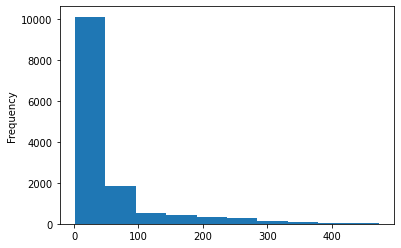

In [ ]:
interes['cantidad de palabras despues de limpieza de memo'].plot.hist()

In [ ]:
resumen = interes[['GRUPOS','cantidad de palabras despues de limpieza de memo'	,'cantidad de palabras Original']].groupby('GRUPOS').sum()
resumen['%de palabras'] = resumen['cantidad de palabras despues de limpieza de memo']/resumen['cantidad de palabras Original']*100
resumen

,cantidad de palabras despues de limpieza de memo,cantidad de palabras Original,%de palabras
GRUPOS,,,
1. Legalización,351689,361800,97.205362
2. Solicitud de educación inclusiva,15326,15765,97.215350
3. Anticipo,185952,192168,96.765330
4. Consulta,65965,68154,96.788156
5. Soporte Plataforma,29771,30952,96.184415
6. Reintegro,11869,12372,95.934368
7. Inscripción,21979,22479,97.775702


In [ ]:
resumen[['cantidad de palabras despues de limpieza de memo'	,'cantidad de palabras Original']].sum()

cantidad de palabras despues de limpieza de memo    682551
cantidad de palabras Original                       703690
dtype: int64

In [ ]:
pd.set_option('display.max_rows', None)
interes['ObservacionSolucion_limpieza1'].value_counts().head(100)

se procede a dar cierre segun correo adjunto                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [ ]:
sal  = interes['ObservacionSolucion_limpieza1'].value_counts()
sal

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
sal.shape

(10957,)

In [ ]:
sal.reset_index().head(10).to_excel('Nuevos_registros_sinmemo.xlsx')

In [ ]:
texto_total = interes['ObservacionSolucion_limpieza1'].sum()

In [ ]:
len(texto_total.split(' ')) #Total de palabras

668804

In [ ]:
pd.Series(texto_total.split(' ')).nunique()

13480

In [ ]:
pd.Series(texto_total.split(' ')).value_counts()

de                                    43572
la                                    26358
el                                    24526
que                                   18876
a                                     16980
en                                    15836
se                                    15821
y                                     11476
por                                   11420
para                                   9392
del                                    8903
su                                     7509
los                                    7426
con                                    7310
solicitud                              6932
no                                     6727
le                                     6608
correo                                 4919
al                                     4827
caso                                   4806
debe                                   4271
institucion                            4120
o                               

In [ ]:
pd.Series(texto_total.split(' ')).value_counts().head(12)

de      43572
la      26358
el      24526
que     18876
a       16980
en      15836
se      15821
y       11476
por     11420
para     9392
del      8903
su       7509
dtype: int64

In [ ]:
pd.Series(texto_total.split(' ')).value_counts().head(10).index

Index(['de', 'la', 'el', 'que', 'a', 'en', 'se', 'y', 'por', 'para'], dtype='object')

In [ ]:
stop_words=['de', 'la', 'el', 'que', 'a', 'en', 'se', 'y', 'por', 'para']

In [ ]:
texto_filtrado_stop_wwords = [i for i in  texto_total.split(' ') if i  not in stop_words] 
#                            [i for i in  texto.split(' ') if i not in stop_words]

In [ ]:
len(texto_filtrado_stop_wwords)

474547

In [ ]:
print(len(texto_total.split(' ')),len(texto_filtrado_stop_wwords))

668804 474547


In [ ]:
pd.Series(texto_filtrado_stop_wwords).value_counts().head(12)

del            8903
su             7509
los            7426
con            7310
solicitud      6932
no             6727
le             6608
correo         4919
al             4827
caso           4806
debe           4271
institucion    4120
dtype: int64

In [ ]:
pd.Series(texto_filtrado_stop_wwords).value_counts().head(12).index

Index(['del', 'su', 'los', 'con', 'solicitud', 'no', 'le', 'correo', 'al',
       'caso', 'debe', 'institucion'],
      dtype='object')

In [ ]:
stop_words=['de', 'la', 'el', 'que', 'a', 'en', 'se', 'y', 'por', 'para']

In [ ]:
temp = texto_filtrado_stop_wwords.copy()
texto_filtrado_stop_wwords = [i for i in  texto_filtrado_stop_wwords if i  not in stop_words] 

In [ ]:
print(len(texto_total.split(' ')),len(texto_filtrado_stop_wwords))

668804 474547


In [ ]:
texto_filtrado_stop_wwords

['realizo',
 'ajuste',
 'semestre',
 'encuentra',
 'proceso',
 'validacionse',
 'informa',
 'peticionaria',
 'este',
 'caso',
 'fue',
 'cancelado',
 'mes',
 'noviembre',
 'degestion',
 'realizada',
 'dando',
 'respuesta',
 'consulta',
 'generada',
 'correo',
 'traza',
 'abajo',
 'nos',
 'permitimos',
 'indicarle',
 'al',
 'realizar',
 'validacion',
 'nuestro',
 'sistema',
 'evidencia',
 'con',
 'caso',
 'no',
 'dia',
 'dio',
 'siguiente',
 'respuesta',
 '',
 'nuevamente',
 'les',
 'solicito',
 'favor',
 'informacion',
 'sobre',
 'tramite',
 'realice',
 'con',
 'guia',
 'no',
 'anticipo',
 'educativo',
 'mi',
 'hijo',
 'sebastian',
 'andres',
 'molano',
 'hoz',
 'al',
 'dia',
 'hoy',
 'no',
 'ha',
 'hecho',
 'realidad',
 'dicha',
 'solicitud',
 'mi',
 'hijo',
 'inicia',
 'las',
 'clases',
 'continuaran',
 'plataforma',
 'virtual',
 'como',
 'ano',
 'cambiara',
 'alternancia',
 'o',
 'presencialidad',
 'dependiendo',
 'injerencia',
 'pandemia',
 'nuestras',
 'vidas',
 'del',
 'autocuidad

In [ ]:
def limpieza_stop(x):
  y = x.split(' ')
  z = [i for i in  y if i  not in stop_words] 
  return  ' '.join(z)
interes['ObservacionSolucion_limpieza_stop_words'] = interes['ObservacionSolucion_limpieza1'].map(lambda x : limpieza_stop(x))

In [ ]:
interes['ObservacionSolucion_limpieza_stop_words'].isnull().sum()

0

In [ ]:
  for i in range(2,6):
    ng = i
    segmento = str.upper("({}-gramas)".format(ng))
    # Iniciar el count vectorizer con stop words personalizado en español
    count_vectorizer = CountVectorizer(stop_words=[],ngram_range=(ng, ng))
    # Ajustar y transformar los términos procesados
    count_data = count_vectorizer.fit_transform(interes['ObservacionSolucion_limpieza_stop_words'] )
    #Visualizar los términos mas comunes
    words,counts = plot_10_most_common_words(count_data, count_vectorizer)
    # buen dia , ecompetro com , com .co 

In [ ]:
# 1,2, 8 quitar
# 3,4,5,6,7  archivo pd maximo, totalidad los soportes, 
# donde, observe, debe, fue, 

https gestiondepersonal ecopetrol com co
pdf 

# Proceso

True     13739
False        9
Name: ObservacionSolucion_limpieza1, dtype: int64

0       1440
566     1440
645     1440
2008    1440
2616    1440
2741    1440
2795    1440
4711    1441
4795    1441
Name: ObservacionSolucion_limpieza1, dtype: int64

In [ ]:
x[0]

' se informa que su caso no puede ser tramitado por oficina virtual ya que a partir de la fecha esta solicitud se debe realizar a traves de la herrameitna de kactus y revisada la documentacion no se presenta error de cargue en kactus se recuerda que este proceso de plan educacional lo debe realizar el trabajador a traves de la herramienta de autogestion kactus la cual esta habilitada para este tipo de requerimiento razon por la cual lo invitamos a ingresar a la herramienta teniendo en cuenta la siguiente ruta iris para el trabajador red de gestion servicios compartidos en linea servicios de personal opcion beneficio educativo o ingresando en el siguiente link https gestiondepersonal ecopetrol com co es importate tener encuenta que todos los documentos deben estar agrupados en un solo archivo pdf debido a que la pataforma kactus no acepta adjutar mas de un archivo los documentos a adjuntar son a formato plan educacional b recibo o certificado de pago c certificado donde de evidencie car

In [ ]:
x[4795]

' se informa que su caso no puede ser tramitado por oficina virtual ya que a partir de la fecha esta solicitud se debe realizar a traves de la herrameitna de kactus y revisada la documentacion no se presenta error de cargue en kactus se recuerda que este proceso de plan educacional lo debe realizar el trabajador a traves de la herramienta de autogestion kactus la cual esta habilitada para este tipo de requerimiento razon por la cual lo invitamos a ingresar a la herramienta teniendo en cuenta la siguiente ruta iris para el trabajador red de gestion servicios compartidos en linea servicios de personal opcion beneficio educativo o ingresando en el siguiente link https gestiondepersonal ecopetrol com co es importate tener encuenta que todos los documentos deben estar agrupados en un solo archivo pdf debido a que la pataforma kactus no acepta adjutar mas de un archivo los documentos a adjuntar son a formato plan educacional b recibo o certificado de pago c certificado donde de evidencie car

In [ ]:
x[0][0]

' '

In [ ]:
x[4795][0]

' '

In [ ]:
pd.Series(x[4795].split(' '))

0                              
1                            se
2                       informa
3                           que
4                            su
5                          caso
6                            no
7                         puede
8                           ser
9                     tramitado
10                          por
11                      oficina
12                      virtual
13                           ya
14                          que
15                            a
16                       partir
17                           de
18                           la
19                        fecha
20                         esta
21                    solicitud
22                           se
23                         debe
24                     realizar
25                            a
26                       traves
27                           de
28                           la
29                  herrameitna
30                           de
31      

In [ ]:
import re
pd.Series(re.split(r'(\s+)', x[4795]))

0                              
1                              
2                            se
3                              
4                       informa
5                              
6                           que
7                              
8                            su
9                              
10                         caso
11                             
12                           no
13                             
14                        puede
15                             
16                          ser
17                             
18                    tramitado
19                             
20                          por
21                             
22                      oficina
23                             
24                      virtual
25                             
26                           ya
27                             
28                          que
29                             
30                            a
31      

In [ ]:
len(x[4795].split(' '))

240

In [ ]:
mapa = [re.split(r'(\s+)', x[0])[:i]!=re.split(r'(\s+)', x[4795])[:i] for i in range(len(re.split(r'(\s+)', x[4795])))]

sum(mapa)

1

In [ ]:
pd.Series(mapa)[mapa]

478    True
dtype: bool

In [ ]:
pd.Series(re.split(r'(\s+)', x[4795]))[:478].tail(10)

468                 electronico
469                            
470    oficinavirtualdepersonal
471                            
472                   ecopetrol
473                            
474                         com
475                            
476                          co
477                            
dtype: object

In [ ]:
pd.Series(re.split(r'(\s+)', x[0])).tail()

472    ecopetrol
473             
474          com
475             
476           co
dtype: object

In [ ]:
interes['ObservacionSolucion_limpieza1'][0]

''

In [ ]:
interes['ObservacionSolucion_limpieza1'].map(lambda x : type(x)).value_counts()

<class 'str'>    13748
Name: ObservacionSolucion_limpieza1, dtype: int64

In [ ]:
interes['ObservacionSolucion_limpieza1'][interes['ObservacionSolucion_limpieza1'].map(lambda x : type(x)!=str)]

Series([], Name: ObservacionSolucion_limpieza1, dtype: object)

In [ ]:
guiones = [
'fecha esta solicitud se debe realizar a traves de la herrameitna de kactus y revisada la documentacion no se presenta error de cargue en kactus',           

]
